# Import Necessary Modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Takeabinary image and a structuring element to perform the following morphological operations

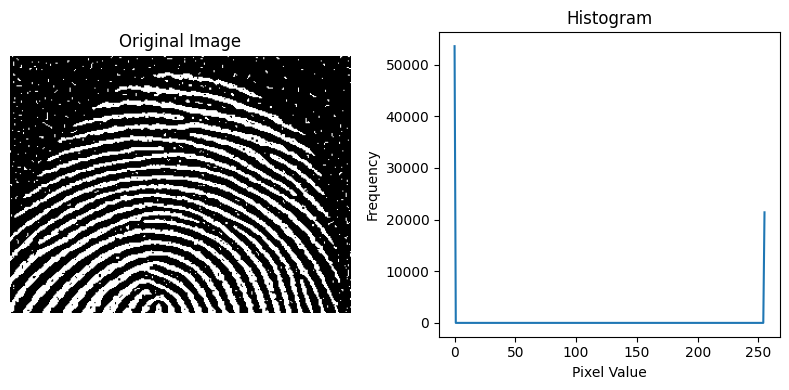

In [ ]:
img = cv2.imread('fingerprint.tif', cv2.IMREAD_GRAYSCALE)

hist = np.zeros(256)

for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    hist[img[i, j]] += 1

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.plot(hist)
plt.title("Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Function for erosion

In [ ]:
def erode_image(binary_image, kernel):
  image = binary_image.copy()
  k_height, k_width = kernel.shape
  pad_h, pad_w = k_height // 2, k_width // 2

  # Pad the image to handle borders
  padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode = 'constant', constant_values=0)
  eroded = np.zeros_like(image)

  for i in range(eroded.shape[0]):
    for j in range(eroded.shape[1]):
      region = padded[i:i + k_height, j:j + k_width]
      # Erode: check if kernel fits completely
      if np.array_equal(region[kernel == 1], 255 * np.ones(np.sum(kernel))):
        eroded[i, j] = 255
      else:
        eroded[i, j] = 0

  return eroded

# Function for dilation

In [ ]:
def dilate_image(binary_image, kernel):
  image = binary_image.copy()
  k_height, k_width = kernel.shape
  pad_h, pad_w = k_height // 2, k_width // 2

  # Pad the image to handle borders
  padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
  dilated = np.zeros_like(image)

  for i in range(dilated.shape[0]):
    for j in range(dilated.shape[1]):
      region = padded[i:i + k_height, j:j + k_width]
      # Dilate: check if kernel fits at least one
      if np.any(region[kernel == 1] == 255):
        dilated[i, j] = 255
      else:
        dilated[i, j] = 0

  return dilated

# (a) Erosion and Dilation operations

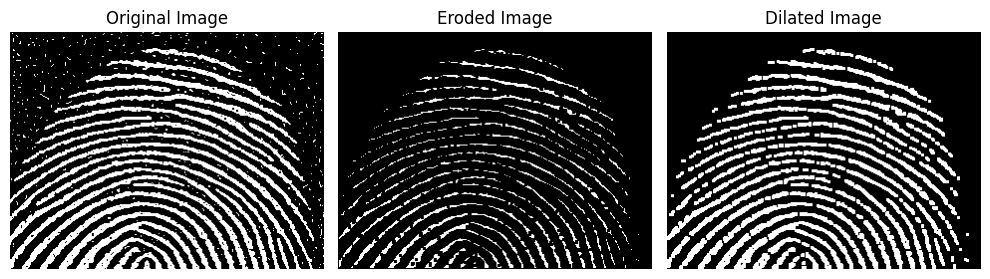

In [ ]:
eroded = erode_image(img, np.ones((3, 3), np.uint8))
dilated = dilate_image(eroded, np.ones((3, 3), np.uint8))

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(eroded, cmap='gray')
plt.title("Eroded Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dilated, cmap='gray')
plt.title("Dilated Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Function to create disk kernel (Stucturing element for opening and closing)

In [ ]:
def create_disk_kernel(radius):
  diameter = 2 * radius + 1
  center = radius
  kernel = np.zeros((diameter, diameter), dtype=np.uint8)

  for i in range(diameter):
    for j in range(diameter):
      if (i - center)**2 + (j - center)**2 <= radius**2:
        kernel[i, j] = 1

  return kernel

# (b) Opening and Closing operations

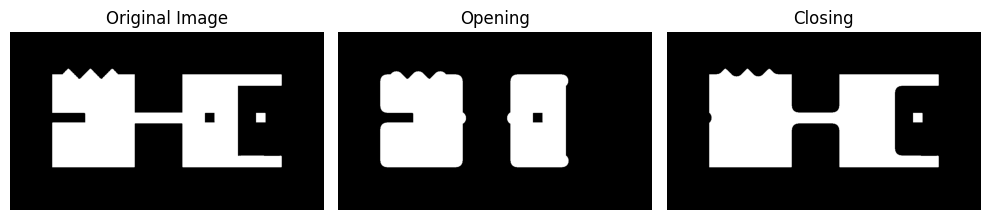

In [33]:
binary_image = cv2.imread('opening_closing.tif', cv2.IMREAD_GRAYSCALE)
kernel = create_disk_kernel(20)
# opening = dilate_image(erode_image(binary_image, np.ones((3, 3), np.uint8)), np.ones((21, 21), np.uint8))
# closing = erode_image(dilate_image(binary_image, np.ones((3, 3), np.uint8)), np.ones((21, 21), np.uint8))

opening = dilate_image(erode_image(binary_image, kernel), kernel)
closing = erode_image(dilate_image(binary_image, kernel), kernel)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(opening, cmap='gray')
plt.title("Opening")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closing, cmap='gray')
plt.title("Closing")
plt.axis('off')

plt.tight_layout()
plt.show()

# (c) Boundary extraction using morphological operation

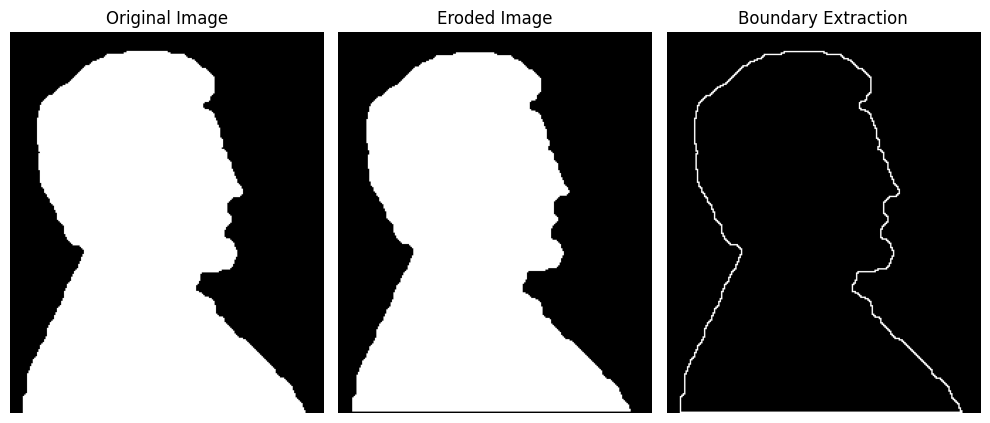

In [35]:
img = cv2.imread('human.tif', cv2.IMREAD_GRAYSCALE)

eroded = erode_image(img, np.ones((3, 3), np.uint8))
boundary = img - eroded

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(eroded, cmap='gray')
plt.title("Eroded Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(boundary, cmap='gray')
plt.title("Boundary Extraction")
plt.axis('off')

plt.tight_layout()
plt.show()

# Function for region filling

In [56]:
def region_filling(image, seed_point, max_iter=1000):
  binary_image = image.copy()
  # Invert image to treat holes as foreground
  A = cv2.bitwise_not(binary_image)

  # Create initial seed image
  X = np.zeros_like(image, dtype=np.uint8)
  X[seed_point[1], seed_point[0]] = 255  # seed_point = (x, y)

  # Structuring element
  kernel = np.ones((3, 3), np.uint8)

  # Iterate until region stops growing or max iterations reached
  for _ in range(max_iter):
    X_new = cv2.dilate(X, kernel)
    X_new = cv2.bitwise_and(X_new, A)

    if np.array_equal(X_new, X):
      break

    X = X_new

  # Combine filled region with original image
  filled_image = cv2.bitwise_or(X, binary_image)
  return filled_image

# (d) Implement the region filling algorithm with morphological operation

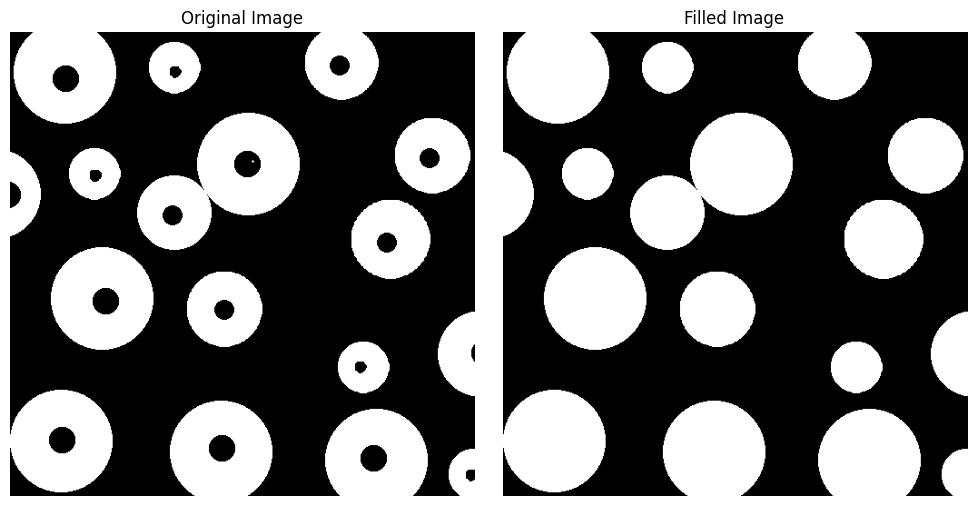

In [57]:
img = cv2.imread('region_filling.tif', cv2.IMREAD_GRAYSCALE)
inverted_img = cv2.bitwise_not(img)

seed = (0, 0)
filled_image = img + cv2.bitwise_not(region_filling(img, seed))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filled_image, cmap='gray')
plt.title("Filled Image")
plt.axis('off')

plt.tight_layout()
plt.show()